In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from PIL import Image
import zipfile
import torch, torchvision
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.data import Dataset
import requests
from io import BytesIO

from torch.utils.data import DataLoader, Subset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm_notebook as tqdm
import copy

In [2]:
pip install kaggle

In [3]:
from google.colab import files

# 上传你的 kaggle.json 文件
uploaded = files.upload()

# 确保 kaggle.json 已上传到正确的位置
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c dogs-vs-cats


 98% 797M/812M [00:03<00:00, 234MB/s]
100% 812M/812M [00:04<00:00, 211MB/s]


In [96]:
# 指定壓縮文件路徑
zip_file_path = '/content/dogs-vs-cats.zip'

# 指定解壓目標文件夾
extracted_folder_path = '/content/dogs-vs-cats'

# 解壓縮文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# 列出解壓後的文件列表
extracted_files = os.listdir(extracted_folder_path)
print("Files extracted successfully:", extracted_files)


Files extracted successfully: ['test1', 'test1.zip', 'sampleSubmission.csv', 'train', 'train.zip']


In [97]:
# 指定已解壓文件夾內壓縮文件的路徑
extracted_folder_path = '/content/dogs-vs-cats'

# 解壓 test1.zip 文件
test_zip_path = os.path.join(extracted_folder_path, 'test1.zip')
with zipfile.ZipFile(test_zip_path, 'r') as test_zip_ref:
    test_zip_ref.extractall(extracted_folder_path)

# 解壓 train.zip 文件
train_zip_path = os.path.join(extracted_folder_path, 'train.zip')
with zipfile.ZipFile(train_zip_path, 'r') as train_zip_ref:
    train_zip_ref.extractall(extracted_folder_path)

# 列出解壓後的文件列表
extracted_files = os.listdir(extracted_folder_path)
print("Files extracted successfully:", extracted_files)


Files extracted successfully: ['test1', 'test1.zip', 'sampleSubmission.csv', 'train', 'train.zip']


In [98]:
csv_file_path = '/content/dogs-vs-cats/sampleSubmission.csv'
df = pd.read_csv(csv_file_path)
print(df.head())


   id  label
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0


In [99]:
# 指定文件夹路径
train_dir = '/content/dogs-vs-cats/train'
test_dir = '/content/dogs-vs-cats/test1'

# 列出文件夹中的文件
test_files = os.listdir(test_dir)
train_files = os.listdir(train_dir)

print("Files in 'test1' folder:", test_files)
print("Files in 'train' folder:", train_files)


Files in 'test1' folder: ['9997.jpg', '1306.jpg', '1346.jpg', '9954.jpg', '6068.jpg', '9910.jpg', '10788.jpg', '7092.jpg', '7973.jpg', '1707.jpg', '10328.jpg', '1292.jpg', '1040.jpg', '4889.jpg', '8964.jpg', '11216.jpg', '8564.jpg', '130.jpg', '6237.jpg', '10140.jpg', '9664.jpg', '2989.jpg', '4696.jpg', '9207.jpg', '9047.jpg', '2196.jpg', '2625.jpg', '7958.jpg', '10482.jpg', '1858.jpg', '996.jpg', '4910.jpg', '8244.jpg', '11782.jpg', '5321.jpg', '1526.jpg', '4792.jpg', '11019.jpg', '9317.jpg', '4962.jpg', '7304.jpg', '5027.jpg', '4883.jpg', '12099.jpg', '7066.jpg', '2257.jpg', '10873.jpg', '5989.jpg', '732.jpg', '149.jpg', '1063.jpg', '1483.jpg', '1301.jpg', '11367.jpg', '10249.jpg', '1566.jpg', '5980.jpg', '4465.jpg', '6741.jpg', '132.jpg', '10726.jpg', '241.jpg', '336.jpg', '5487.jpg', '11845.jpg', '7312.jpg', '4437.jpg', '12202.jpg', '10219.jpg', '8954.jpg', '4451.jpg', '7852.jpg', '2060.jpg', '2817.jpg', '3142.jpg', '11957.jpg', '7172.jpg', '6607.jpg', '743.jpg', '5754.jpg', '859.j

In [100]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

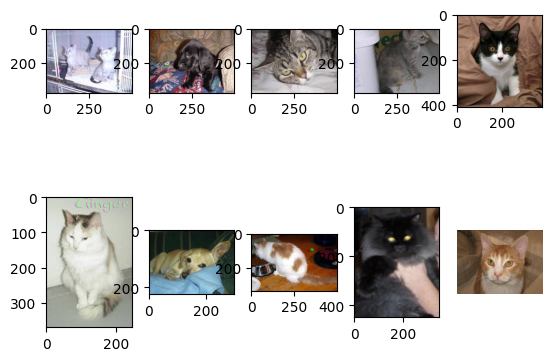

In [101]:
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [102]:
class DogCatDataset(Dataset):
    def __init__(self, file_list, mode='train', transform=None):
        self.file_list = file_list
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        label = img_path.split('/')[-1].split('.')[0]
        if self.mode == 'train':
            label = 0 if  label =='cat'  else 1
            return image, label
        else:
            return image



In [103]:
train_folder_path = '/content/dogs-vs-cats/train'
test_folder_path = '/content/dogs-vs-cats/test1'

In [104]:
from sklearn.model_selection import train_test_split
train_list,valid_list = train_test_split(train_list, test_size =0.2)
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [105]:
batch_size = 32
def load_data():
  train_data = DogCatDataset(train_list, mode='train', transform=train_transforms)
  valid_data = DogCatDataset(valid_list, mode='train',transform=valid_transforms)
  test_data = DogCatDataset(test_list, mode='valid', transform=test_transforms)
  num_workers = 6
  train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size,shuffle = True, num_workers = num_workers)
  valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size = batch_size,shuffle = False, num_workers = num_workers)
  test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size,shuffle = False, num_workers = num_workers)
  print(len(train_data),len(train_loader))
  print(len(valid_data), len(valid_loader))
  return train_loader, valid_loader, test_loader

In [106]:
train_loader, valid_loader, test_loader = load_data()

20000 625
5000 157


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [107]:
# 取得資料加載器的迭代器，取得一個批次的數據
data_iter = iter(valid_loader)
images, labels = next(data_iter)
print(images.shape)  # 輸出圖片的形狀
print(labels)        # 輸出標籤

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0])


In [108]:
model = torchvision.models.resnet34(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
for param in model.parameters():
    param.requires_grad = True

In [110]:
num_classes = 2
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512), nn.ReLU(),nn.Dropout(),nn.Linear(512, num_classes)
)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [111]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def validate_model(model, val_loader, device= DEVICE):
    model = model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_accuracy

In [112]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total if total > 0 else 0.0

def evaluate_loss(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    return running_loss / total_samples if total_samples > 0 else 0.0


In [113]:
pip install optuna

In [114]:
epochs = 7
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def train_model(model, train_loader, val_loader, lr=LEARNING_RATE, device=DEVICE, epochs=epochs):
    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

    running_loss = 0.0
    max_accuracy = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_accuracy = evaluate_accuracy(model, train_loader, device)
        val_accuracy = evaluate_accuracy(model, val_loader, device)
        accuracies['train'].append(train_accuracy)
        accuracies['val'].append(val_accuracy)

        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_loss(model, val_loader, device)
        losses['train'].append(train_loss)
        losses['val'].append(val_loss)
        running_loss = 0.0  # Reset running_loss for the next epoch

        print(f"Epoch: {epoch+1}/{epochs} - Train Accuracy: {train_accuracy:.4f} - Val Accuracy: {val_accuracy:.4f} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        scheduler.step(val_accuracy)

        if val_accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = val_accuracy
            print(f"Saving best model with accuracy: {val_accuracy:.4f}")

    # Plotting loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses['train'], label='Training Loss')
    plt.plot(losses['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies['train'], label='Training Accuracy')
    plt.plot(accuracies['val'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return best_model




<ipython-input-114-96625f5ff7bd>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, labels in tqdm(train_loader):


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1/7 - Train Accuracy: 0.9285 - Val Accuracy: 0.9234 - Train Loss: 0.2152 - Val Loss: 0.1824
Saving best model with accuracy: 0.9234


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2/7 - Train Accuracy: 0.9652 - Val Accuracy: 0.9530 - Train Loss: 0.1370 - Val Loss: 0.1166
Saving best model with accuracy: 0.9530


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3/7 - Train Accuracy: 0.9587 - Val Accuracy: 0.9504 - Train Loss: 0.1084 - Val Loss: 0.1428


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4/7 - Train Accuracy: 0.9613 - Val Accuracy: 0.9482 - Train Loss: 0.0974 - Val Loss: 0.1376


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5/7 - Train Accuracy: 0.9658 - Val Accuracy: 0.9438 - Train Loss: 0.0773 - Val Loss: 0.1624


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6/7 - Train Accuracy: 0.9776 - Val Accuracy: 0.9588 - Train Loss: 0.0816 - Val Loss: 0.1095
Saving best model with accuracy: 0.9588


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7/7 - Train Accuracy: 0.9840 - Val Accuracy: 0.9608 - Train Loss: 0.0589 - Val Loss: 0.1084
Saving best model with accuracy: 0.9608


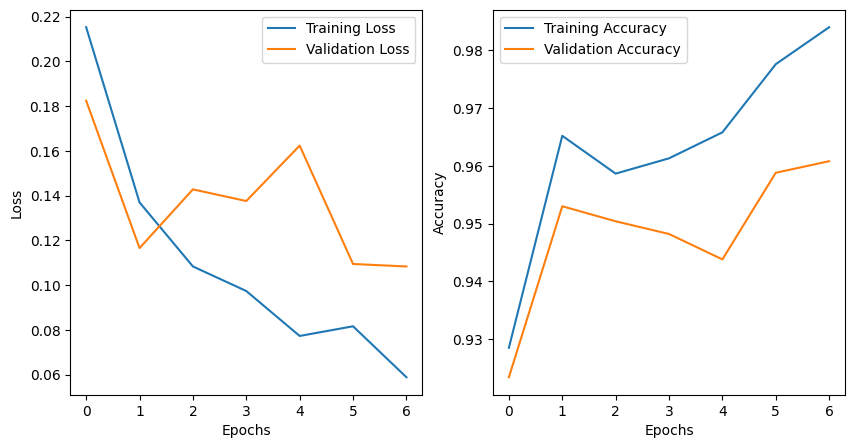

In [115]:
resnet = train_model(model, train_loader, valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


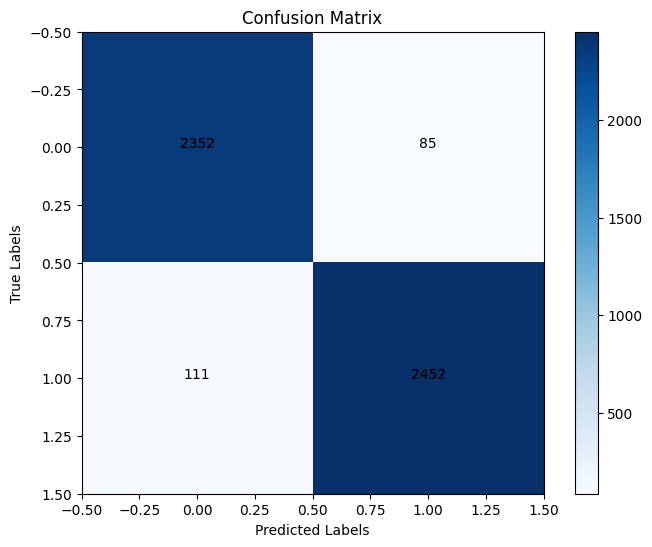

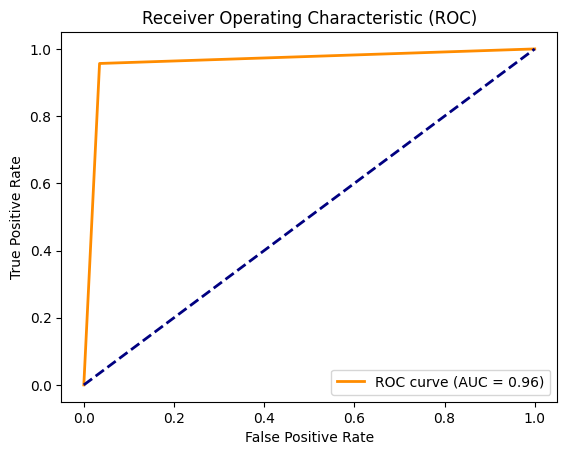

Accuracy: 0.96
Precision: 0.97
Recall: 0.96
Confusion Matrix:
[[2352   85]
 [ 111 2452]]


In [120]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    confusion = confusion_matrix(all_labels, all_predictions)

    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion, cmap='Blues', interpolation='nearest')
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="black")
            if i == j:
                plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="black")

    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, confusion

accuracy, precision, recall, confusion = evaluate_model(model, valid_loader, DEVICE)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(confusion)

In [117]:
# Function to predict labels
def predict(model, test_loader):
    model.eval()
    predictions = []
    for images in tqdm(test_loader):
        images = images.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

predicted_labels = predict(model, test_loader)
print(predicted_labels)


<ipython-input-117-2e291b956178>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images in tqdm(test_loader):


  0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

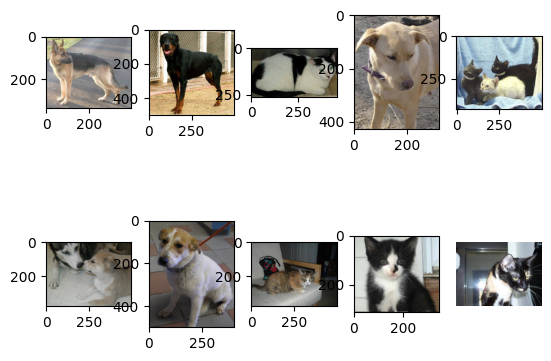

[1, 1, 0, 1, 0, 1, 1, 0, 0, 0]


In [118]:
random_idx = np.arange(10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(test_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()
print(predicted_labels[:10])